In [1]:
# --- CELL 1: SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
%matplotlib inline

# Đường dẫn
DATA_DIR = os.path.join('..', 'data')
MODEL_DIR = os.path.join('..', 'model')
os.makedirs(MODEL_DIR, exist_ok=True)

print("⏱️ OPS AI: Hệ thống tối ưu vận hành đã sẵn sàng!")

⏱️ OPS AI: Hệ thống tối ưu vận hành đã sẵn sàng!


In [2]:
# --- CELL 2: LOAD & AGGREGATE DATA ---

# 1. Load dữ liệu
trips = pd.read_csv(os.path.join(DATA_DIR, 'trips.csv'))
routes = pd.read_csv(os.path.join(DATA_DIR, 'routes.csv'))
fuel = pd.read_csv(os.path.join(DATA_DIR, 'fuel_purchases.csv'))
events = pd.read_csv(os.path.join(DATA_DIR, 'delivery_events.csv'))
loads = pd.read_csv(os.path.join(DATA_DIR, 'loads.csv')) # Cần để lấy route_id

print(f"🔹 Trips: {trips.shape}")
print(f"🔹 Fuel Records: {fuel.shape}")
print(f"🔹 Delivery Events: {events.shape}")

# 2. Tính tổng nhiên liệu thực tế cho mỗi chuyến
trip_fuel = fuel.groupby('trip_id')['gallons'].sum().reset_index(name='actual_fuel_gallons')

# 3. Tính tổng thời gian chờ (Detention) tại kho
trip_detention = events.groupby('trip_id')['detention_minutes'].sum().reset_index(name='total_detention_min')

print("✅ Đã tổng hợp dữ liệu nhiên liệu và thời gian chờ!")
trip_detention.head()

🔹 Trips: (85410, 12)
🔹 Fuel Records: (196442, 11)
🔹 Delivery Events: (170820, 11)
✅ Đã tổng hợp dữ liệu nhiên liệu và thời gian chờ!


,trip_id,total_detention_min
0,TRIP00000001,230
1,TRIP00000002,129
2,TRIP00000003,94
3,TRIP00000004,192
4,TRIP00000005,309


In [3]:
# --- CELL 3: MERGE & FEATURE ENGINEERING ---

# Lấy trips làm gốc
master = trips.copy()

# Ghép route_id từ bảng loads (Cầu nối quan trọng)
master = master.merge(loads[['load_id', 'route_id']], on='load_id', how='left')

# Ghép thông tin lộ trình chuẩn (để biết đi bao lâu là chuẩn)
master = master.merge(routes[['route_id', 'typical_transit_days', 'typical_distance_miles']], on='route_id', how='left')

# Ghép nhiên liệu & thời gian chờ
master = master.merge(trip_fuel, on='trip_id', how='left')
master = master.merge(trip_detention, on='trip_id', how='left')

# --- TÍNH TOÁN CHỈ SỐ ---

# 1. Xử lý nhiên liệu & MPG (Miles Per Gallon)
# Nếu không có dữ liệu đổ xăng, dùng tạm cột fuel_gallons_used có sẵn
master['actual_fuel_gallons'] = master['actual_fuel_gallons'].fillna(master['fuel_gallons_used'])
# Tránh chia cho 0
fuel_used = np.where(master['actual_fuel_gallons'] <= 0.1, 1, master['actual_fuel_gallons'])
master['real_mpg'] = master['actual_distance_miles'] / fuel_used

# 2. Xử lý thời gian chờ (Đổi ra giờ)
master['total_detention_min'] = master['total_detention_min'].fillna(0)
master['detention_hours'] = master['total_detention_min'] / 60

# 3. Tính độ trễ (Delay Gap)
# Giờ thực tế - (Ngày chuẩn * 24h)
standard_hours = master['typical_transit_days'] * 24
master['delay_hours'] = master['actual_duration_hours'] - standard_hours
master['delay_hours'] = master['delay_hours'].fillna(0) # Nếu thiếu thì coi như không trễ

print(f"🎉 Hồ sơ vận hành hoàn chỉnh: {master.shape}")
master[['trip_id', 'real_mpg', 'detention_hours', 'delay_hours']].head()

🎉 Hồ sơ vận hành hoàn chỉnh: (85410, 20)


,trip_id,real_mpg,detention_hours,delay_hours
0,TRIP00000001,6.530815,3.833333,-21.8
1,TRIP00000002,2.742279,2.150000,-15.4
2,TRIP00000003,2.702208,1.566667,-51.0
3,TRIP00000004,6.500453,3.200000,-12.9
4,TRIP00000005,16.113506,5.150000,-37.0


In [4]:
# --- CELL 4: LABELING (ĐỊNH NGHĨA HIỆU QUẢ) ---

# Logic đánh giá:
# 0: HIỆU QUẢ (Efficient) - Tiết kiệm xăng, ít chờ đợi, đúng giờ.
# 1: KÉM HIỆU QUẢ (Inefficient) - Tốn xăng, chờ lâu, hoặc trễ giờ.

# Điều kiện Kém:
cond_inefficient = (
    (master['detention_hours'] > 4) |       # Chờ quá 4 tiếng tại kho
    (master['real_mpg'] < 5.0) |            # Tốn xăng (dưới 5 dặm/gallon)
    (master['delay_hours'] > 5)             # Trễ hơn quy định 5 tiếng
)

master['ops_rating'] = np.where(cond_inefficient, 1, 0)

print("📊 Phân bố hiệu quả vận hành (0: Tốt, 1: Kém):")
counts = master['ops_rating'].value_counts()
print(counts)

if len(counts) < 2:
    print("⚠️ CẢNH BÁO: Dữ liệu bị lệch! Hãy nới lỏng điều kiện ở trên.")

📊 Phân bố hiệu quả vận hành (0: Tốt, 1: Kém):
ops_rating
1    53947
0    31463
Name: count, dtype: int64


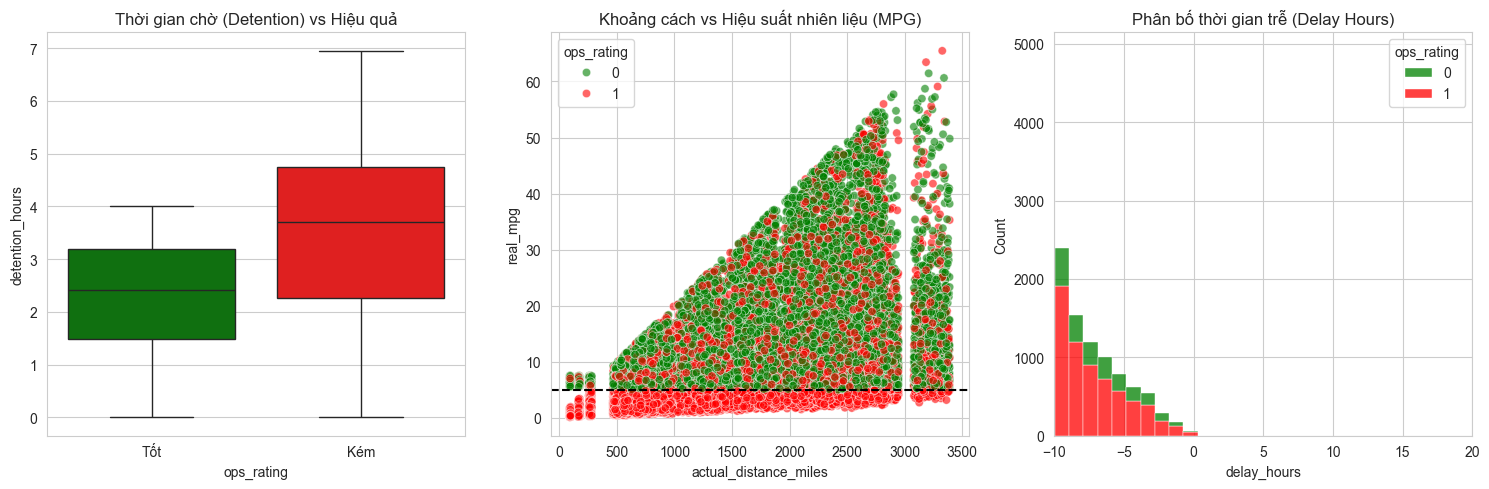

In [5]:
# --- CELL 5: VISUALIZATION ---

plt.figure(figsize=(15, 5))

# Palette màu động (tránh lỗi nếu chỉ có 1 class)
unique_labels = master['ops_rating'].unique()
my_palette = ['green', 'red'] if len(unique_labels) > 1 else ['green']

# Biểu đồ 1: Thời gian chờ vs Đánh giá
plt.subplot(1, 3, 1)
sns.boxplot(data=master, x='ops_rating', y='detention_hours', hue='ops_rating', legend=False, palette=my_palette)
plt.title('Thời gian chờ (Detention) vs Hiệu quả')
plt.xticks([0, 1] if len(unique_labels) > 1 else [0], ['Tốt', 'Kém'] if len(unique_labels) > 1 else ['Tốt'])

# Biểu đồ 2: MPG vs Khoảng cách
plt.subplot(1, 3, 2)
sns.scatterplot(data=master, x='actual_distance_miles', y='real_mpg', hue='ops_rating', palette=my_palette, alpha=0.6)
plt.title('Khoảng cách vs Hiệu suất nhiên liệu (MPG)')
plt.axhline(5.0, color='black', linestyle='--') # Mốc 5 MPG

# Biểu đồ 3: Phân bố độ trễ
plt.subplot(1, 3, 3)
sns.histplot(data=master, x='delay_hours', hue='ops_rating', multiple="stack", palette=my_palette)
plt.title('Phân bố thời gian trễ (Delay Hours)')
plt.xlim(-10, 20) # Zoom vào khoảng quan trọng

plt.tight_layout()
plt.show()

In [6]:
# --- CELL 6: PREPARE FOR TRAINING ---

# Chọn Features
features = ['detention_hours', 'real_mpg', 'delay_hours', 'actual_distance_miles']
X = master[features]
y = master['ops_rating']

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"📚 Dữ liệu học: {X_train.shape}")
print(f"📝 Dữ liệu thi: {X_test.shape}")

📚 Dữ liệu học: (68328, 4)
📝 Dữ liệu thi: (17082, 4)


In [7]:
# --- CELL 7: TRAINING WITH TUNING ---

print("🧠 Đang tối ưu hóa mô hình Ops AI...")

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced'] # Cân bằng giữa chuyến tốt và chuyến xấu
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_ops_model = grid_search.best_estimator_

print(f"🏆 Tham số tốt nhất: {grid_search.best_params_}")
print("✅ Training hoàn tất!")

🧠 Đang tối ưu hóa mô hình Ops AI...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
🏆 Tham số tốt nhất: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
✅ Training hoàn tất!


In [8]:
# --- CELL 8: EVALUATION & EXPORT ---

y_pred = best_ops_model.predict(X_test)

# 1. Độ chính xác
acc = accuracy_score(y_test, y_pred)
print(f"🎯 ĐỘ CHÍNH XÁC (ACCURACY): {acc*100:.2f}%")

# 2. Báo cáo chi tiết
print("\n📜 Classification Report:")
print(classification_report(y_test, y_pred))

# 3. Feature Importance
importances = pd.Series(best_ops_model.feature_importances_, index=features).sort_values(ascending=False)
print("\n⭐ Yếu tố ảnh hưởng đến hiệu quả vận hành:")
print(importances)

# 4. Lưu Model
save_path = os.path.join(MODEL_DIR, 'ops_ai.pkl')
joblib.dump(best_ops_model, save_path)
print(f"💾 Đã lưu model Ops AI vào: {os.path.abspath(save_path)}")

🎯 ĐỘ CHÍNH XÁC (ACCURACY): 100.00%

📜 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6326
           1       1.00      1.00      1.00     10756

    accuracy                           1.00     17082
   macro avg       1.00      1.00      1.00     17082
weighted avg       1.00      1.00      1.00     17082


⭐ Yếu tố ảnh hưởng đến hiệu quả vận hành:
real_mpg                 0.622580
detention_hours          0.328650
actual_distance_miles    0.036045
delay_hours              0.012725
dtype: float64
💾 Đã lưu model Ops AI vào: D:\logistics_AI\model\ops_ai.pkl
